# Wave Equation: Vibrating String

## Introduction

The **wave equation** is a second-order linear partial differential equation that describes the propagation of waves—such as mechanical waves on a string, sound waves in air, or electromagnetic waves in vacuum. In this notebook, we focus on the classical problem of a **vibrating string** fixed at both ends, which historically motivated the development of Fourier analysis.

## Mathematical Formulation

### The One-Dimensional Wave Equation

Consider a string of length $L$ stretched between two fixed endpoints. Let $u(x, t)$ denote the transverse displacement of the string at position $x$ and time $t$. The wave equation governing this displacement is:

$$\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$$

where $c = \sqrt{T/\mu}$ is the **wave speed**, with:
- $T$ = tension in the string (N)
- $\mu$ = linear mass density (kg/m)

### Boundary Conditions

For a string fixed at both ends:

$$u(0, t) = 0 \quad \text{and} \quad u(L, t) = 0 \quad \text{for all } t \geq 0$$

### Initial Conditions

The solution requires specification of:
- **Initial displacement**: $u(x, 0) = f(x)$
- **Initial velocity**: $\frac{\partial u}{\partial t}(x, 0) = g(x)$

## Analytical Solution via Separation of Variables

Assuming a separable solution $u(x, t) = X(x)T(t)$, we obtain:

$$\frac{T''}{c^2 T} = \frac{X''}{X} = -\lambda$$

This yields the eigenvalue problem:

$$X'' + \lambda X = 0, \quad X(0) = X(L) = 0$$

The eigenvalues and eigenfunctions are:

$$\lambda_n = \left(\frac{n\pi}{L}\right)^2, \quad X_n(x) = \sin\left(\frac{n\pi x}{L}\right), \quad n = 1, 2, 3, \ldots$$

The general solution is:

$$u(x, t) = \sum_{n=1}^{\infty} \left[ A_n \cos\left(\frac{n\pi c t}{L}\right) + B_n \sin\left(\frac{n\pi c t}{L}\right) \right] \sin\left(\frac{n\pi x}{L}\right)$$

where the Fourier coefficients are determined by:

$$A_n = \frac{2}{L} \int_0^L f(x) \sin\left(\frac{n\pi x}{L}\right) dx$$

$$B_n = \frac{2}{n\pi c} \int_0^L g(x) \sin\left(\frac{n\pi x}{L}\right) dx$$

## Numerical Solution: Finite Difference Method

We discretize space and time on a grid:
- $x_i = i \Delta x$, $i = 0, 1, \ldots, N_x$
- $t_j = j \Delta t$, $j = 0, 1, \ldots, N_t$

The second-order central difference approximation gives:

$$\frac{u_i^{j+1} - 2u_i^j + u_i^{j-1}}{(\Delta t)^2} = c^2 \frac{u_{i+1}^j - 2u_i^j + u_{i-1}^j}{(\Delta x)^2}$$

Solving for $u_i^{j+1}$:

$$u_i^{j+1} = 2u_i^j - u_i^{j-1} + r^2 \left( u_{i+1}^j - 2u_i^j + u_{i-1}^j \right)$$

where $r = c \Delta t / \Delta x$ is the **Courant number**. For stability, we require the **CFL condition**:

$$r \leq 1$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Simulation Parameters

We define the physical and numerical parameters for our simulation.

In [2]:
# Physical parameters
L = 1.0          # Length of string (m)
c = 1.0          # Wave speed (m/s)
T_final = 2.0    # Total simulation time (s)

# Numerical parameters
Nx = 100         # Number of spatial points
dx = L / Nx      # Spatial step size

# CFL condition: r = c*dt/dx <= 1 for stability
r = 0.5          # Courant number (chosen for stability)
dt = r * dx / c  # Time step size
Nt = int(T_final / dt) + 1  # Number of time steps

# Grid
x = np.linspace(0, L, Nx + 1)
t = np.linspace(0, T_final, Nt)

print(f"Spatial step: dx = {dx:.4f} m")
print(f"Time step: dt = {dt:.4f} s")
print(f"Courant number: r = {r}")
print(f"Number of time steps: {Nt}")

Spatial step: dx = 0.0100 m
Time step: dt = 0.0050 s
Courant number: r = 0.5
Number of time steps: 401


## Initial Conditions

We consider a plucked string with initial displacement:

$$f(x) = \begin{cases} 
\frac{2h x}{L} & \text{if } x \leq L/2 \\
\frac{2h(L - x)}{L} & \text{if } x > L/2
\end{cases}$$

This represents a triangular shape with maximum displacement $h$ at the center. Initial velocity is zero: $g(x) = 0$.

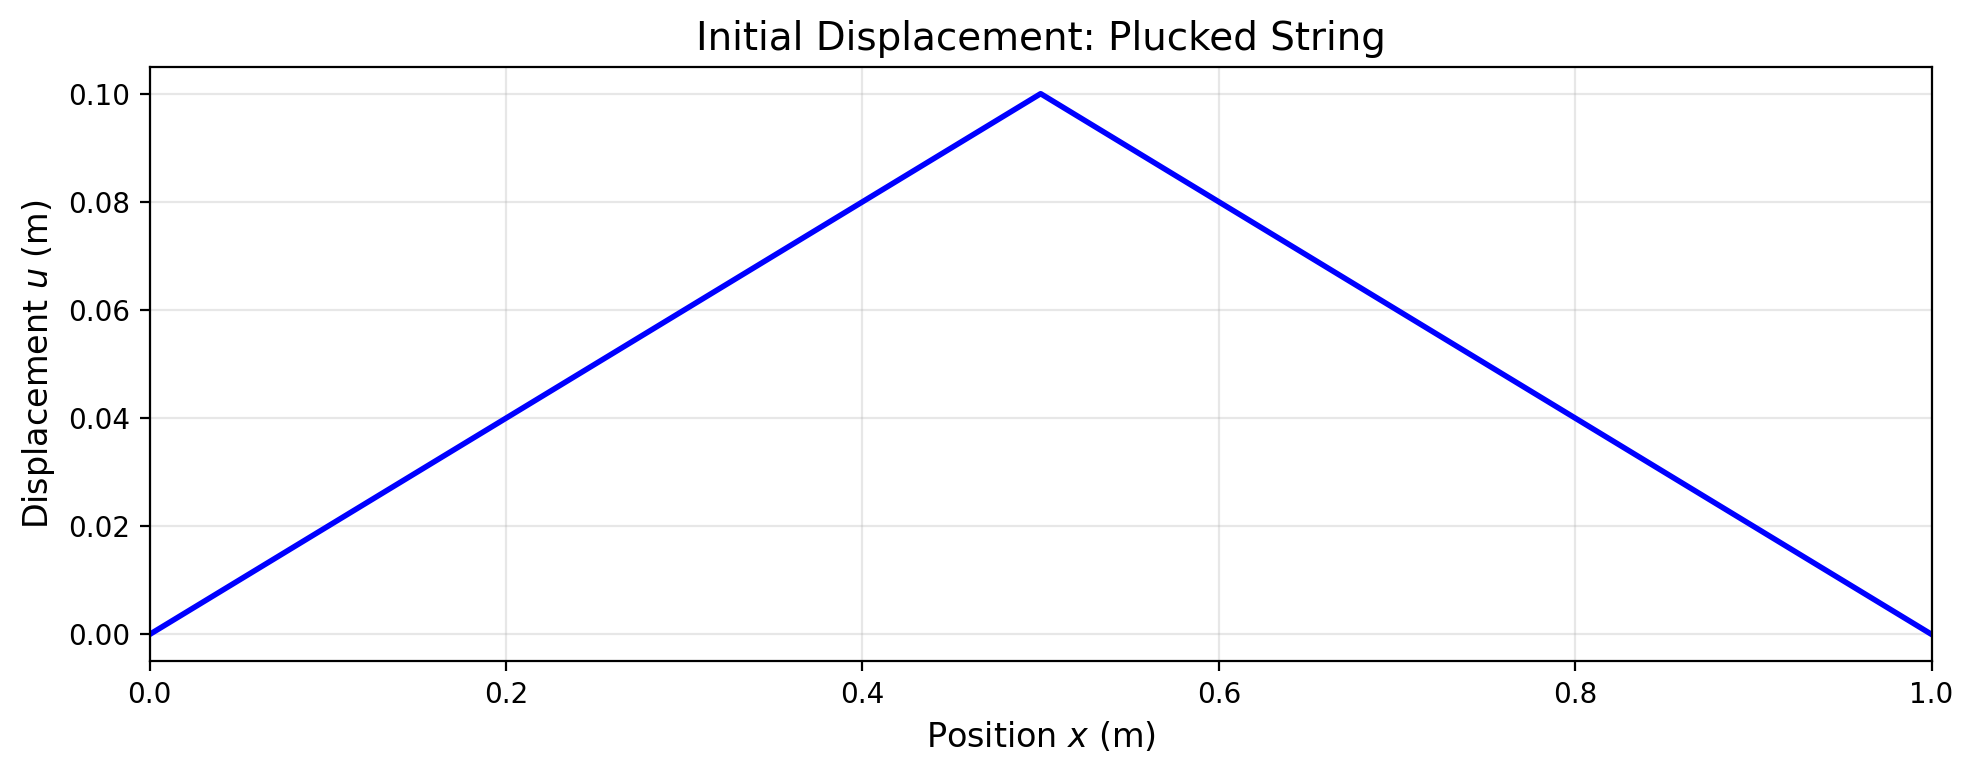

In [3]:
def initial_displacement(x, L, h=0.1):
    """Triangular pluck initial condition."""
    return np.where(x <= L/2, 2*h*x/L, 2*h*(L - x)/L)

def initial_velocity(x):
    """Zero initial velocity."""
    return np.zeros_like(x)

# Set initial conditions
h = 0.1  # Maximum displacement amplitude
u_initial = initial_displacement(x, L, h)
v_initial = initial_velocity(x)

# Visualize initial condition
plt.figure(figsize=(10, 4))
plt.plot(x, u_initial, 'b-', linewidth=2)
plt.xlabel('Position $x$ (m)', fontsize=12)
plt.ylabel('Displacement $u$ (m)', fontsize=12)
plt.title('Initial Displacement: Plucked String', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(0, L)
plt.tight_layout()
plt.show()

## Finite Difference Solver

We implement the explicit finite difference scheme to solve the wave equation.

In [4]:
def solve_wave_equation(x, t, c, u0, v0):
    """
    Solve the 1D wave equation using finite differences.
    
    Parameters:
    -----------
    x : array
        Spatial grid points
    t : array
        Time grid points
    c : float
        Wave speed
    u0 : array
        Initial displacement
    v0 : array
        Initial velocity
    
    Returns:
    --------
    u : 2D array
        Solution u(x, t)
    """
    Nx = len(x) - 1
    Nt = len(t)
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    r = c * dt / dx
    r2 = r**2
    
    # Initialize solution array
    u = np.zeros((Nt, Nx + 1))
    
    # Set initial displacement
    u[0, :] = u0
    
    # Compute first time step using initial velocity
    # u(x, dt) ≈ u(x, 0) + dt * v(x, 0) + (dt²/2) * c² * u_xx(x, 0)
    for i in range(1, Nx):
        u[1, i] = (u[0, i] + dt * v0[i] + 
                   0.5 * r2 * (u[0, i+1] - 2*u[0, i] + u[0, i-1]))
    
    # Apply boundary conditions
    u[1, 0] = 0
    u[1, Nx] = 0
    
    # Time-stepping loop
    for j in range(1, Nt - 1):
        for i in range(1, Nx):
            u[j+1, i] = (2*u[j, i] - u[j-1, i] + 
                        r2 * (u[j, i+1] - 2*u[j, i] + u[j, i-1]))
        
        # Apply boundary conditions
        u[j+1, 0] = 0
        u[j+1, Nx] = 0
    
    return u

# Solve the wave equation
u = solve_wave_equation(x, t, c, u_initial, v_initial)
print(f"Solution computed: shape = {u.shape}")

Solution computed: shape = (401, 101)


## Visualization of Wave Propagation

### Snapshots at Different Times

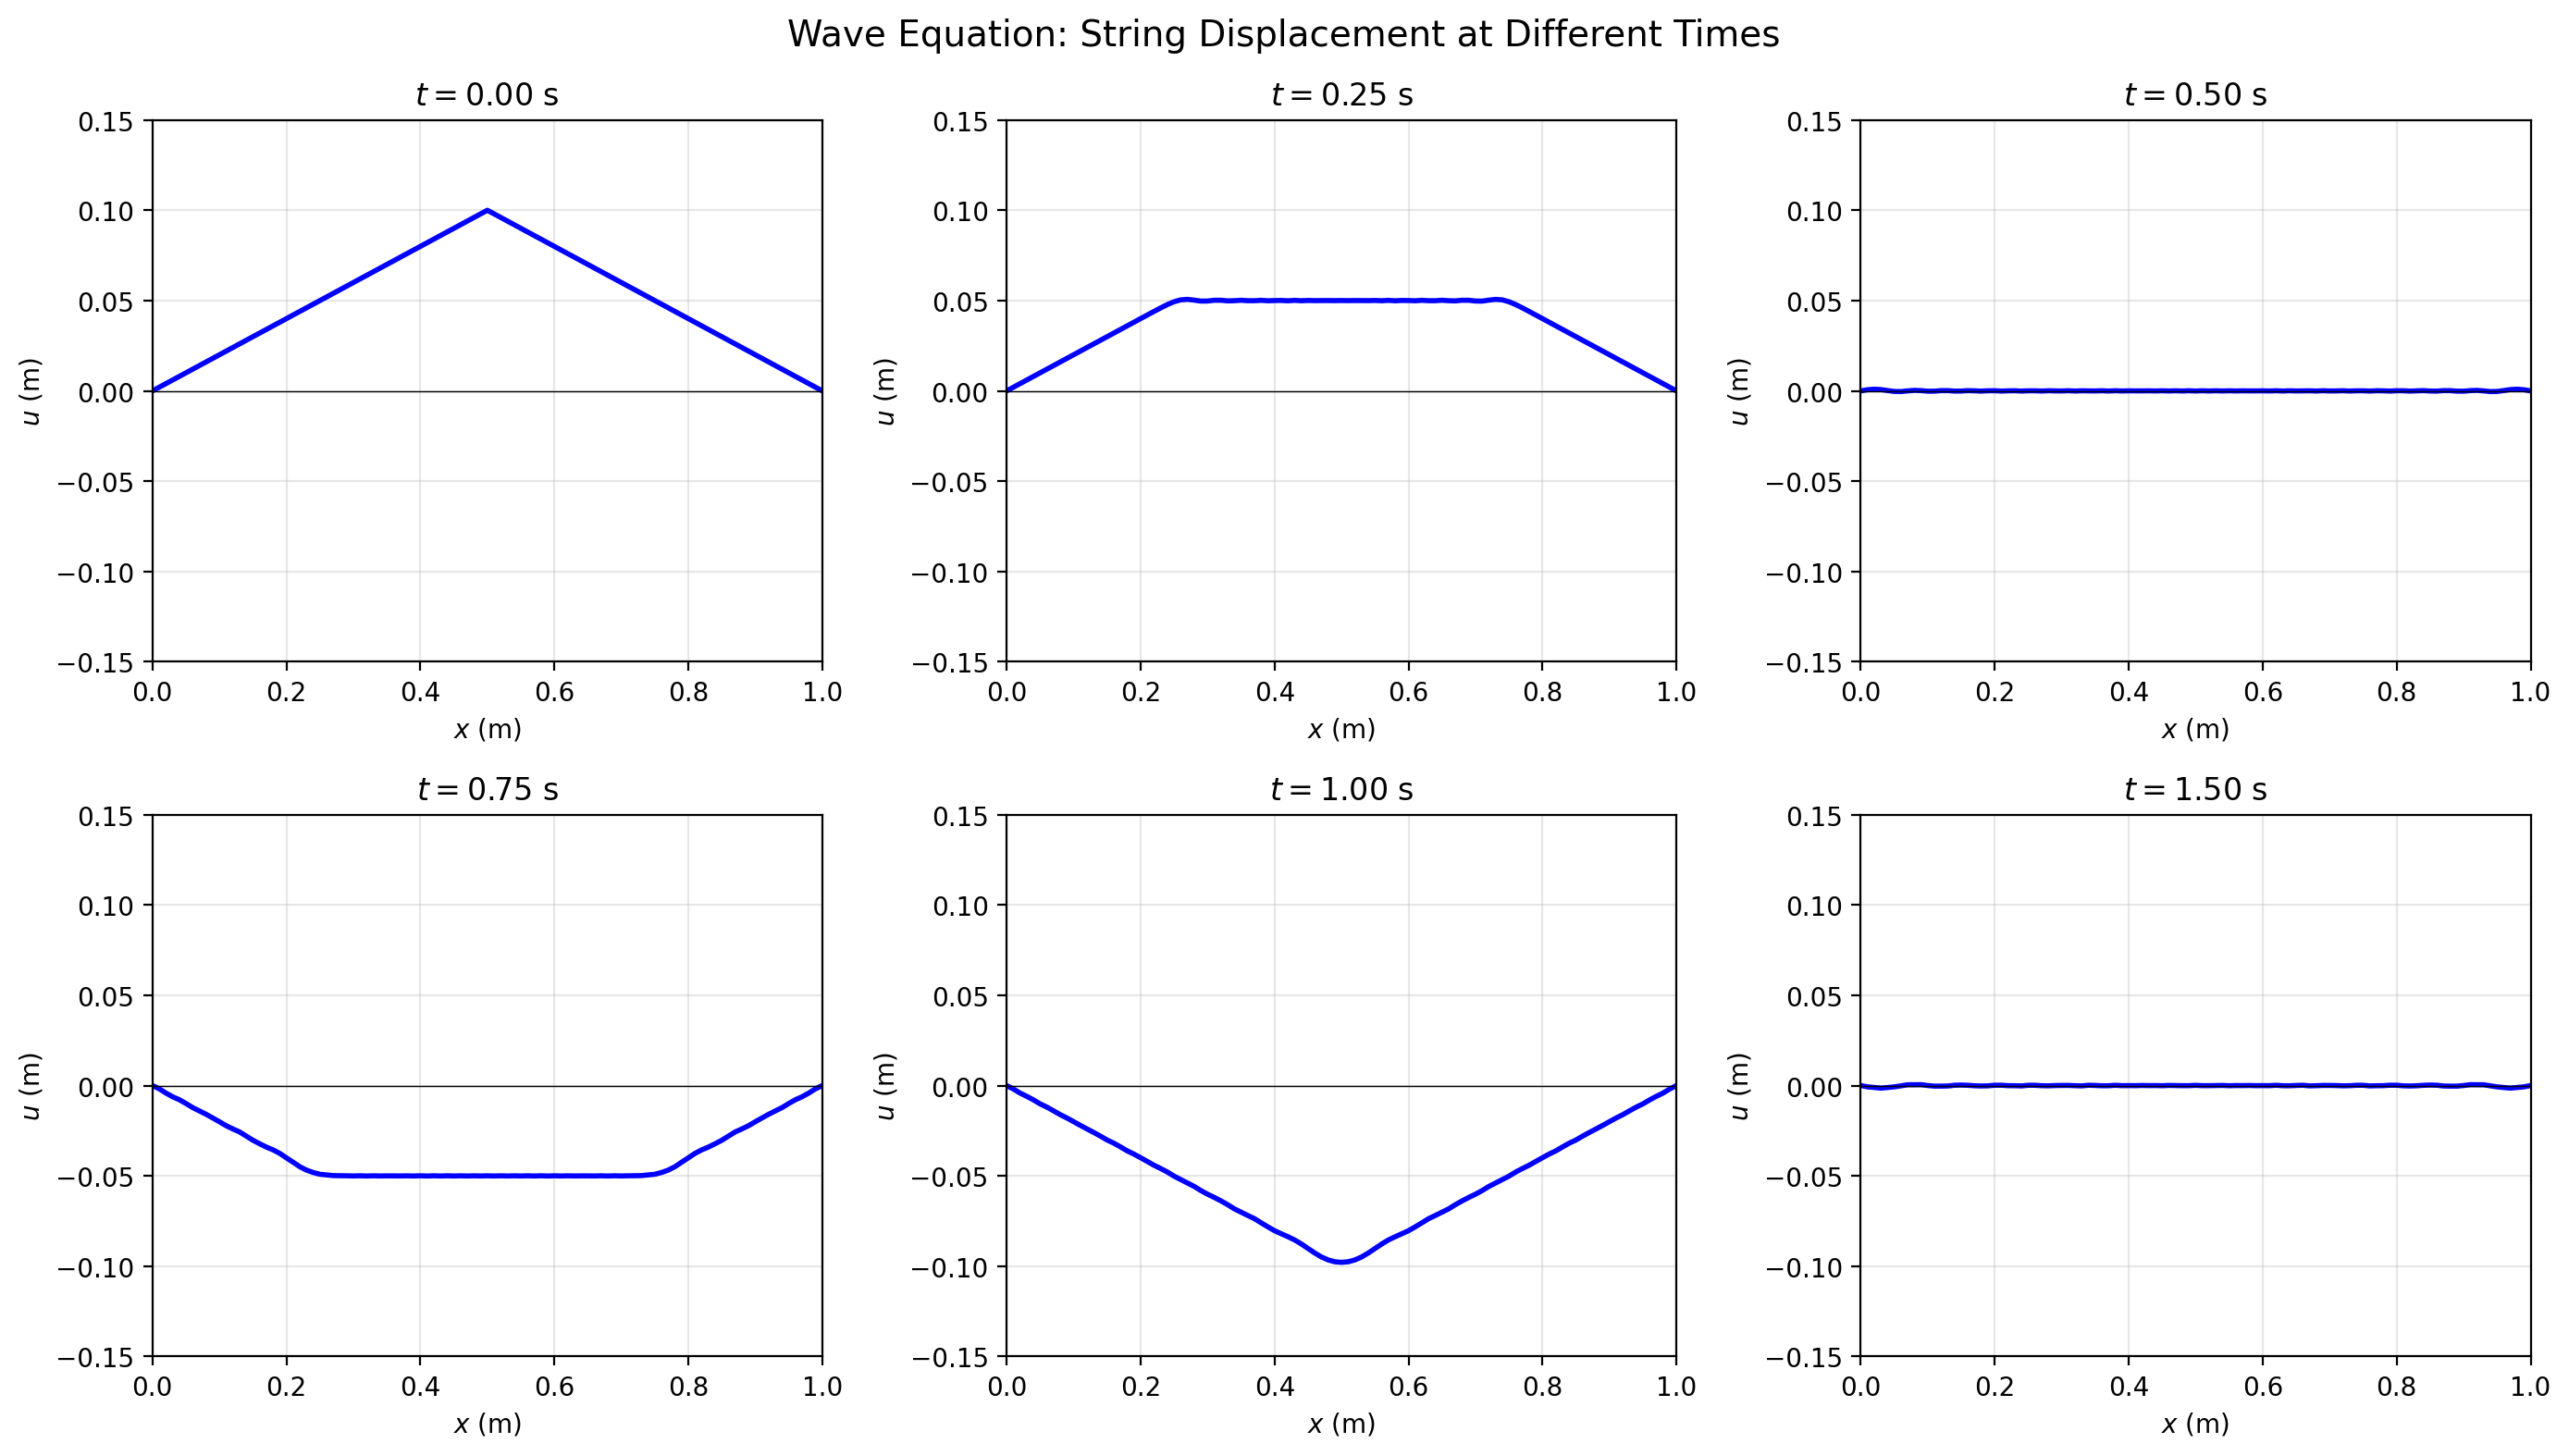

In [5]:
# Plot snapshots at different times
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

time_snapshots = [0, 0.25, 0.5, 0.75, 1.0, 1.5]

for ax, t_snap in zip(axes, time_snapshots):
    idx = int(t_snap / dt)
    if idx >= Nt:
        idx = Nt - 1
    ax.plot(x, u[idx, :], 'b-', linewidth=2)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.set_xlabel('$x$ (m)')
    ax.set_ylabel('$u$ (m)')
    ax.set_title(f'$t = {t[idx]:.2f}$ s')
    ax.set_xlim(0, L)
    ax.set_ylim(-0.15, 0.15)
    ax.grid(True, alpha=0.3)

plt.suptitle('Wave Equation: String Displacement at Different Times', fontsize=14)
plt.tight_layout()
plt.show()

### Space-Time Surface Plot

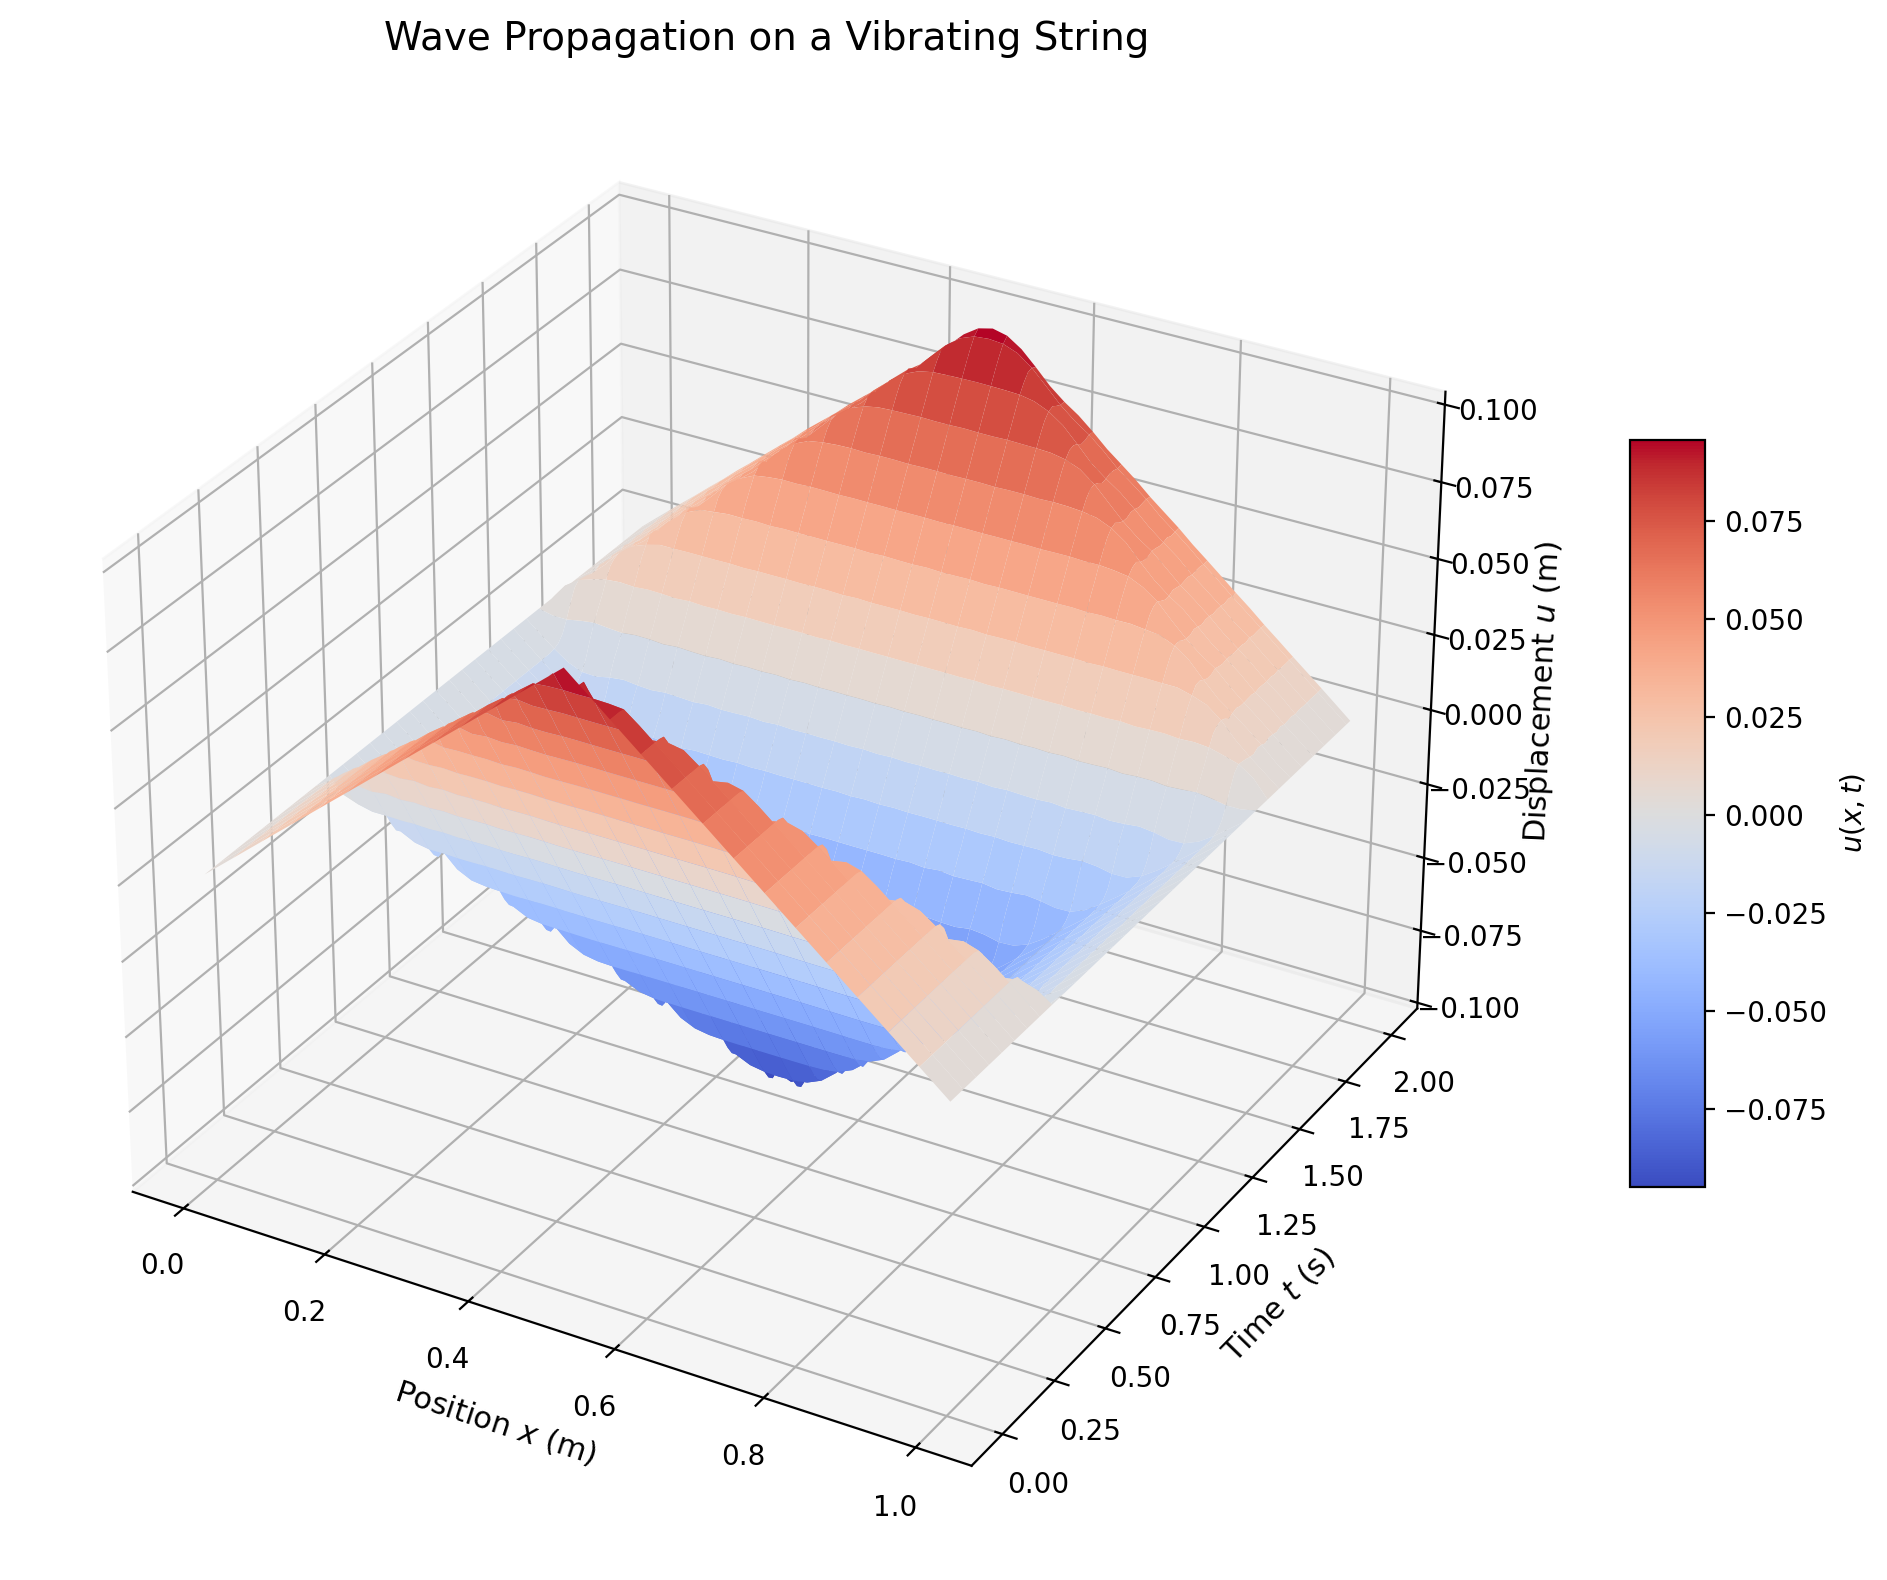

In [6]:
# Create meshgrid for 3D plot
X, T = np.meshgrid(x, t)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Downsample for clearer visualization
skip_t = max(1, Nt // 100)
skip_x = max(1, (Nx + 1) // 50)

surf = ax.plot_surface(X[::skip_t, ::skip_x], T[::skip_t, ::skip_x], 
                       u[::skip_t, ::skip_x],
                       cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_xlabel('Position $x$ (m)', fontsize=11)
ax.set_ylabel('Time $t$ (s)', fontsize=11)
ax.set_zlabel('Displacement $u$ (m)', fontsize=11)
ax.set_title('Wave Propagation on a Vibrating String', fontsize=14)

fig.colorbar(surf, shrink=0.5, aspect=10, label='$u(x,t)$')
plt.tight_layout()
plt.show()

## Energy Conservation Analysis

The total mechanical energy of the vibrating string is:

$$E = \frac{1}{2} \int_0^L \left[ \mu \left(\frac{\partial u}{\partial t}\right)^2 + T \left(\frac{\partial u}{\partial x}\right)^2 \right] dx$$

This should be conserved for an ideal string with no damping.

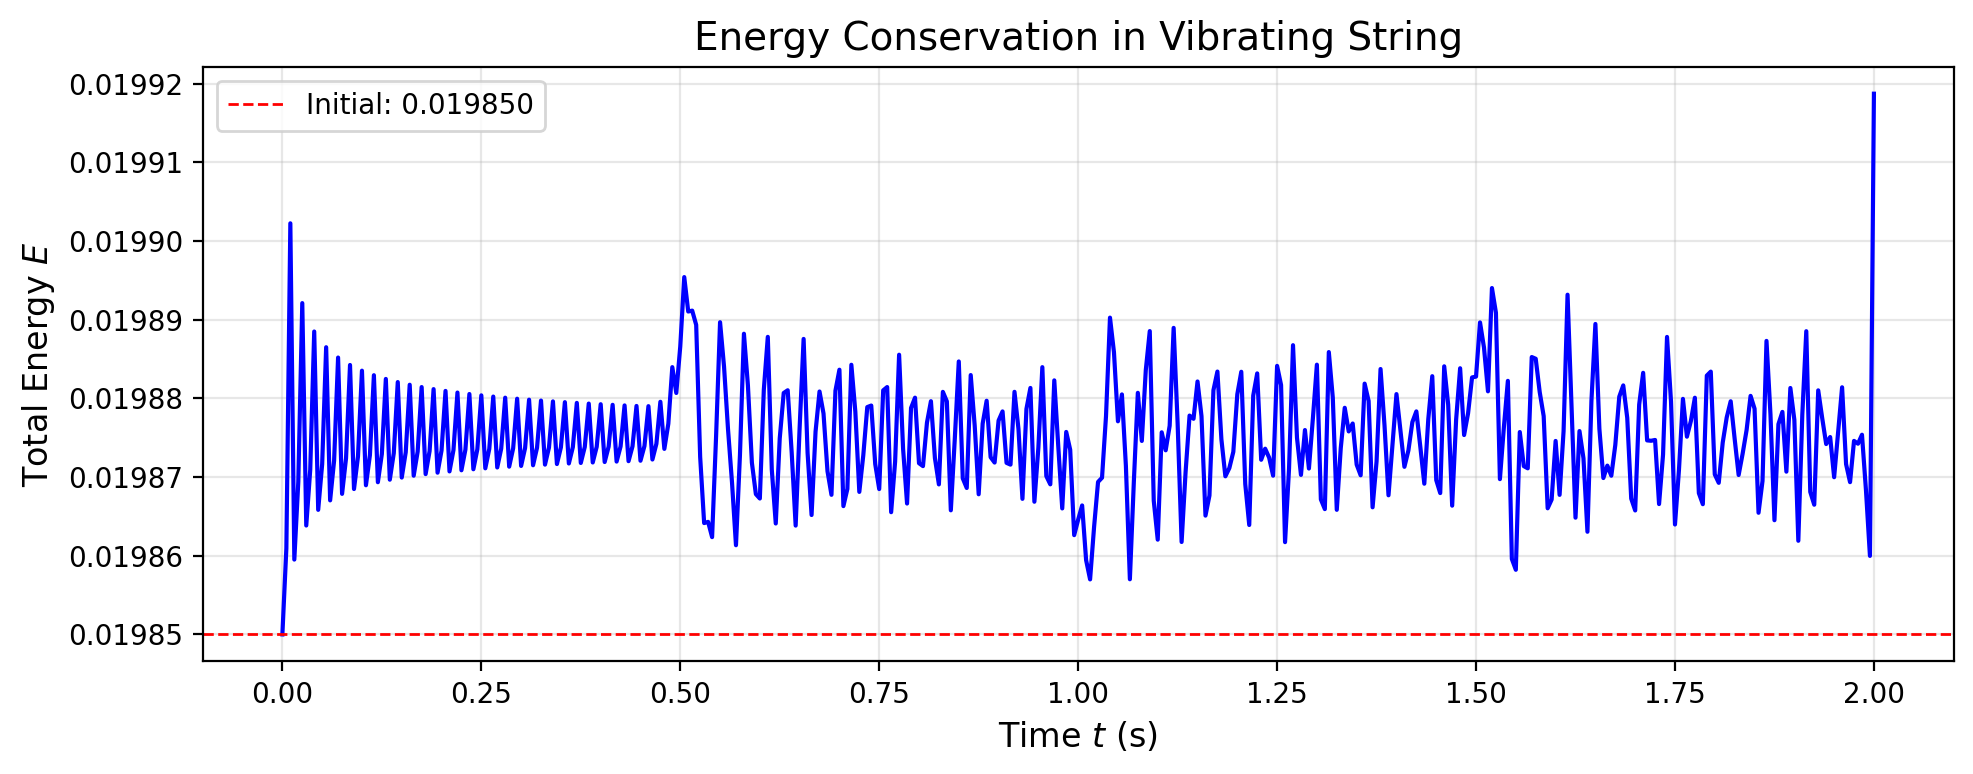

Initial energy: 0.019850
Final energy: 0.019919
Energy drift: 0.3462%


In [7]:
def compute_energy(u, dx, dt, c):
    """
    Compute the total energy of the string at each time step.
    
    E = (1/2) * integral[ (du/dt)^2 + c^2*(du/dx)^2 ] dx
    """
    Nt = u.shape[0]
    energy = np.zeros(Nt)
    
    for j in range(Nt):
        # Spatial derivative (central difference for interior)
        du_dx = np.gradient(u[j, :], dx)
        
        # Time derivative (forward/backward difference at boundaries)
        if j == 0:
            du_dt = (u[1, :] - u[0, :]) / dt
        elif j == Nt - 1:
            du_dt = (u[j, :] - u[j-1, :]) / dt
        else:
            du_dt = (u[j+1, :] - u[j-1, :]) / (2 * dt)
        
        # Energy density
        kinetic = 0.5 * du_dt**2
        potential = 0.5 * c**2 * du_dx**2
        
        # Total energy (trapezoidal integration)
        energy[j] = np.trapezoid(kinetic + potential, dx=dx)
    
    return energy

# Compute energy over time
energy = compute_energy(u, dx, dt, c)

plt.figure(figsize=(10, 4))
plt.plot(t, energy, 'b-', linewidth=1.5)
plt.xlabel('Time $t$ (s)', fontsize=12)
plt.ylabel('Total Energy $E$', fontsize=12)
plt.title('Energy Conservation in Vibrating String', fontsize=14)
plt.grid(True, alpha=0.3)

# Calculate energy drift
E_initial = energy[0]
E_final = energy[-1]
drift = abs(E_final - E_initial) / E_initial * 100

plt.axhline(y=E_initial, color='r', linestyle='--', linewidth=1, 
            label=f'Initial: {E_initial:.6f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Initial energy: {E_initial:.6f}")
print(f"Final energy: {E_final:.6f}")
print(f"Energy drift: {drift:.4f}%")

## Fourier Mode Analysis

The vibrating string can be decomposed into its normal modes (harmonics). For a plucked string, the Fourier coefficients are:

$$A_n = \frac{8h}{(n\pi)^2} \sin\left(\frac{n\pi}{2}\right)$$

This shows that only odd harmonics are excited (since $\sin(n\pi/2) = 0$ for even $n$).

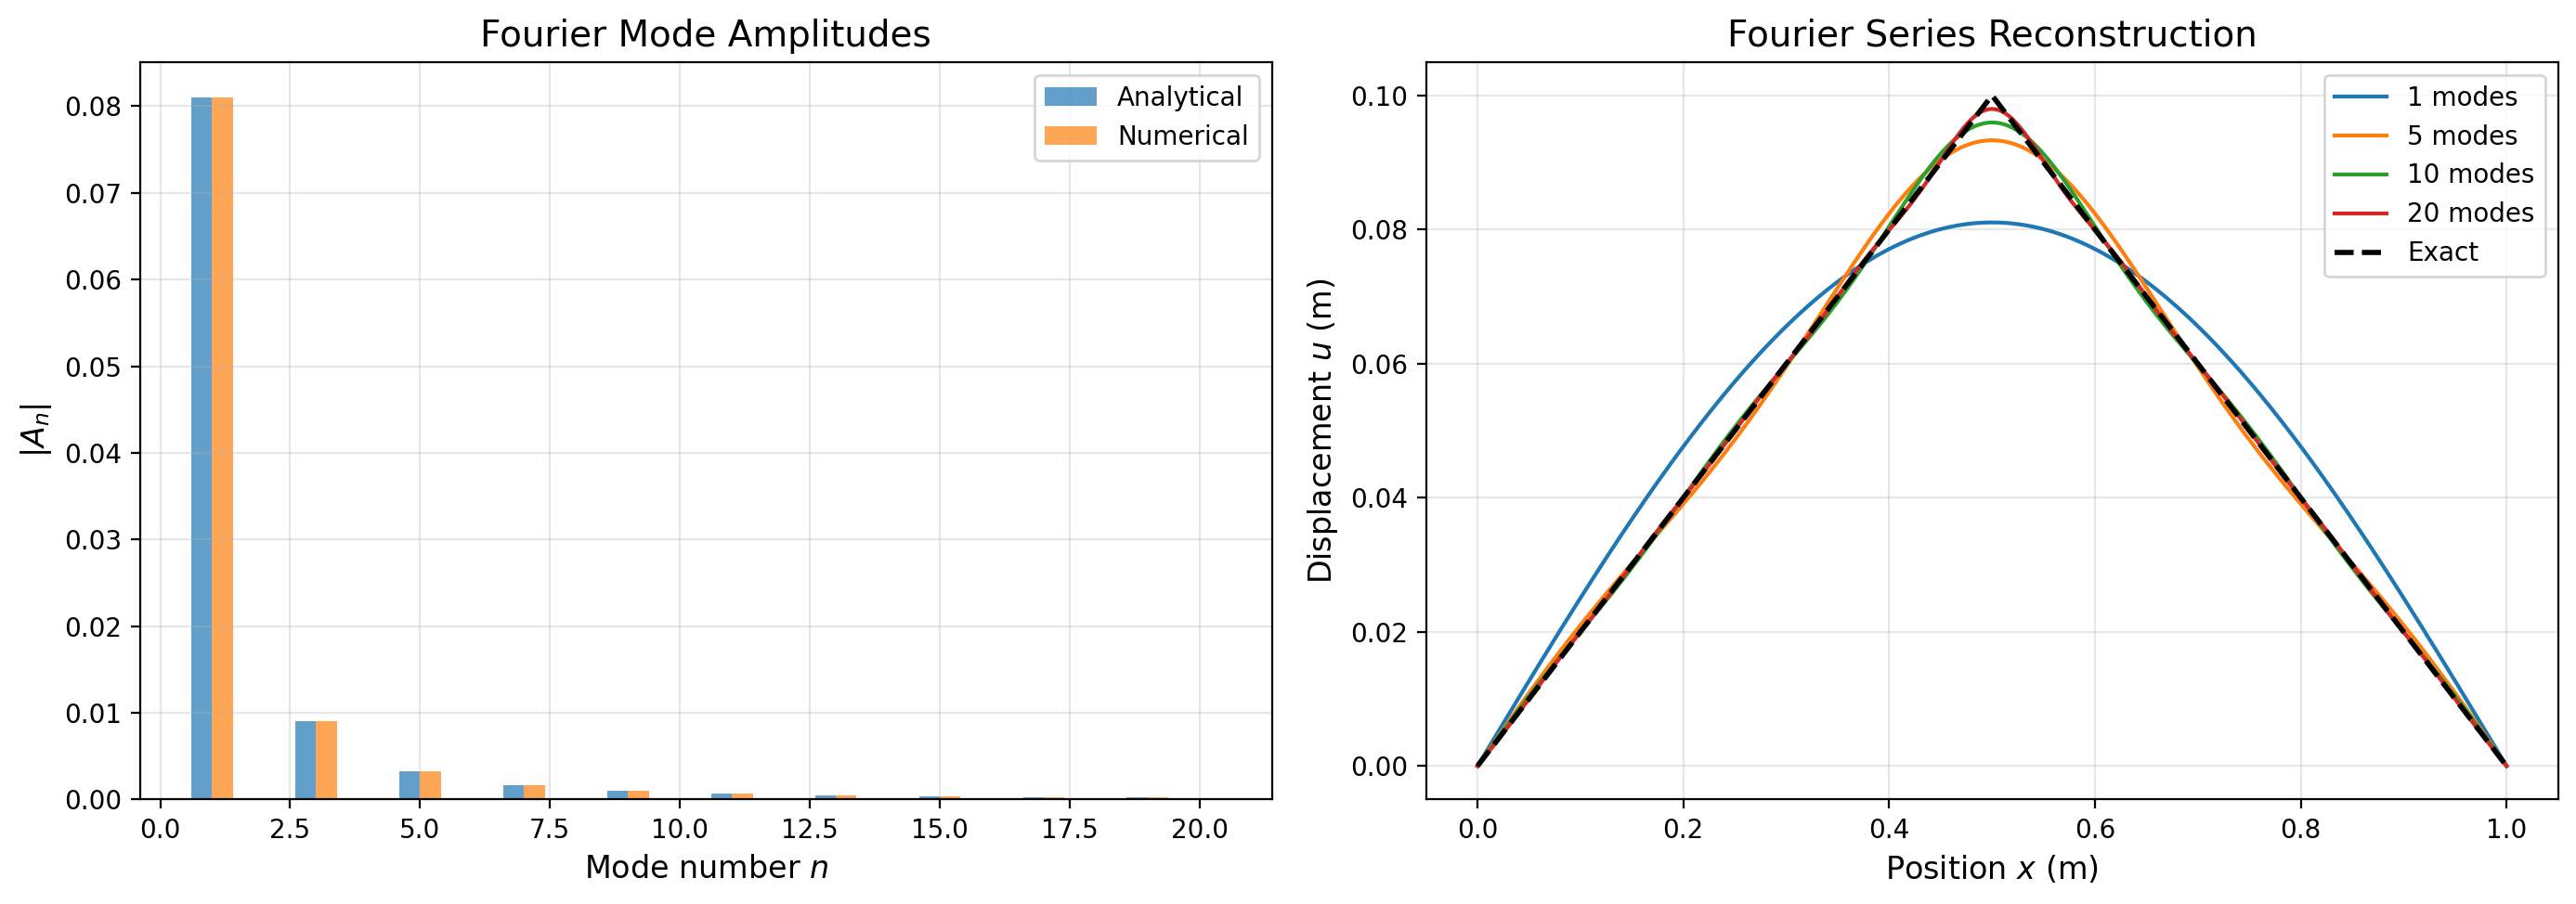

In [8]:
def analytical_fourier_coefficients(n_modes, h, L):
    """Compute Fourier coefficients for triangular pluck."""
    n = np.arange(1, n_modes + 1)
    A_n = 8 * h / (n * np.pi)**2 * np.sin(n * np.pi / 2)
    return n, A_n

def numerical_fourier_coefficients(u, x, L, n_modes):
    """Compute Fourier coefficients numerically."""
    coeffs = []
    for n in range(1, n_modes + 1):
        phi_n = np.sin(n * np.pi * x / L)
        A_n = 2/L * np.trapezoid(u * phi_n, x)
        coeffs.append(A_n)
    return np.arange(1, n_modes + 1), np.array(coeffs)

# Compare analytical and numerical coefficients
n_modes = 20
n_anal, A_anal = analytical_fourier_coefficients(n_modes, h, L)
n_num, A_num = numerical_fourier_coefficients(u_initial, x, L, n_modes)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mode amplitudes
axes[0].bar(n_anal - 0.2, np.abs(A_anal), width=0.4, label='Analytical', alpha=0.7)
axes[0].bar(n_num + 0.2, np.abs(A_num), width=0.4, label='Numerical', alpha=0.7)
axes[0].set_xlabel('Mode number $n$', fontsize=12)
axes[0].set_ylabel('$|A_n|$', fontsize=12)
axes[0].set_title('Fourier Mode Amplitudes', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruct signal from modes
def reconstruct_from_modes(x, L, A_n, t_val, c):
    """Reconstruct u(x, t) from Fourier modes."""
    u_recon = np.zeros_like(x)
    for n, A in enumerate(A_n, start=1):
        omega_n = n * np.pi * c / L
        u_recon += A * np.cos(omega_n * t_val) * np.sin(n * np.pi * x / L)
    return u_recon

# Reconstruct at t=0 with different number of modes
x_fine = np.linspace(0, L, 500)
for n_max in [1, 5, 10, 20]:
    u_recon = reconstruct_from_modes(x_fine, L, A_anal[:n_max], 0, c)
    axes[1].plot(x_fine, u_recon, label=f'{n_max} modes')

axes[1].plot(x, u_initial, 'k--', linewidth=2, label='Exact')
axes[1].set_xlabel('Position $x$ (m)', fontsize=12)
axes[1].set_ylabel('Displacement $u$ (m)', fontsize=12)
axes[1].set_title('Fourier Series Reconstruction', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Final Visualization: Wave Dynamics Summary

We create a comprehensive visualization showing the wave propagation alongside the energy profile.

Figure saved to plot.png


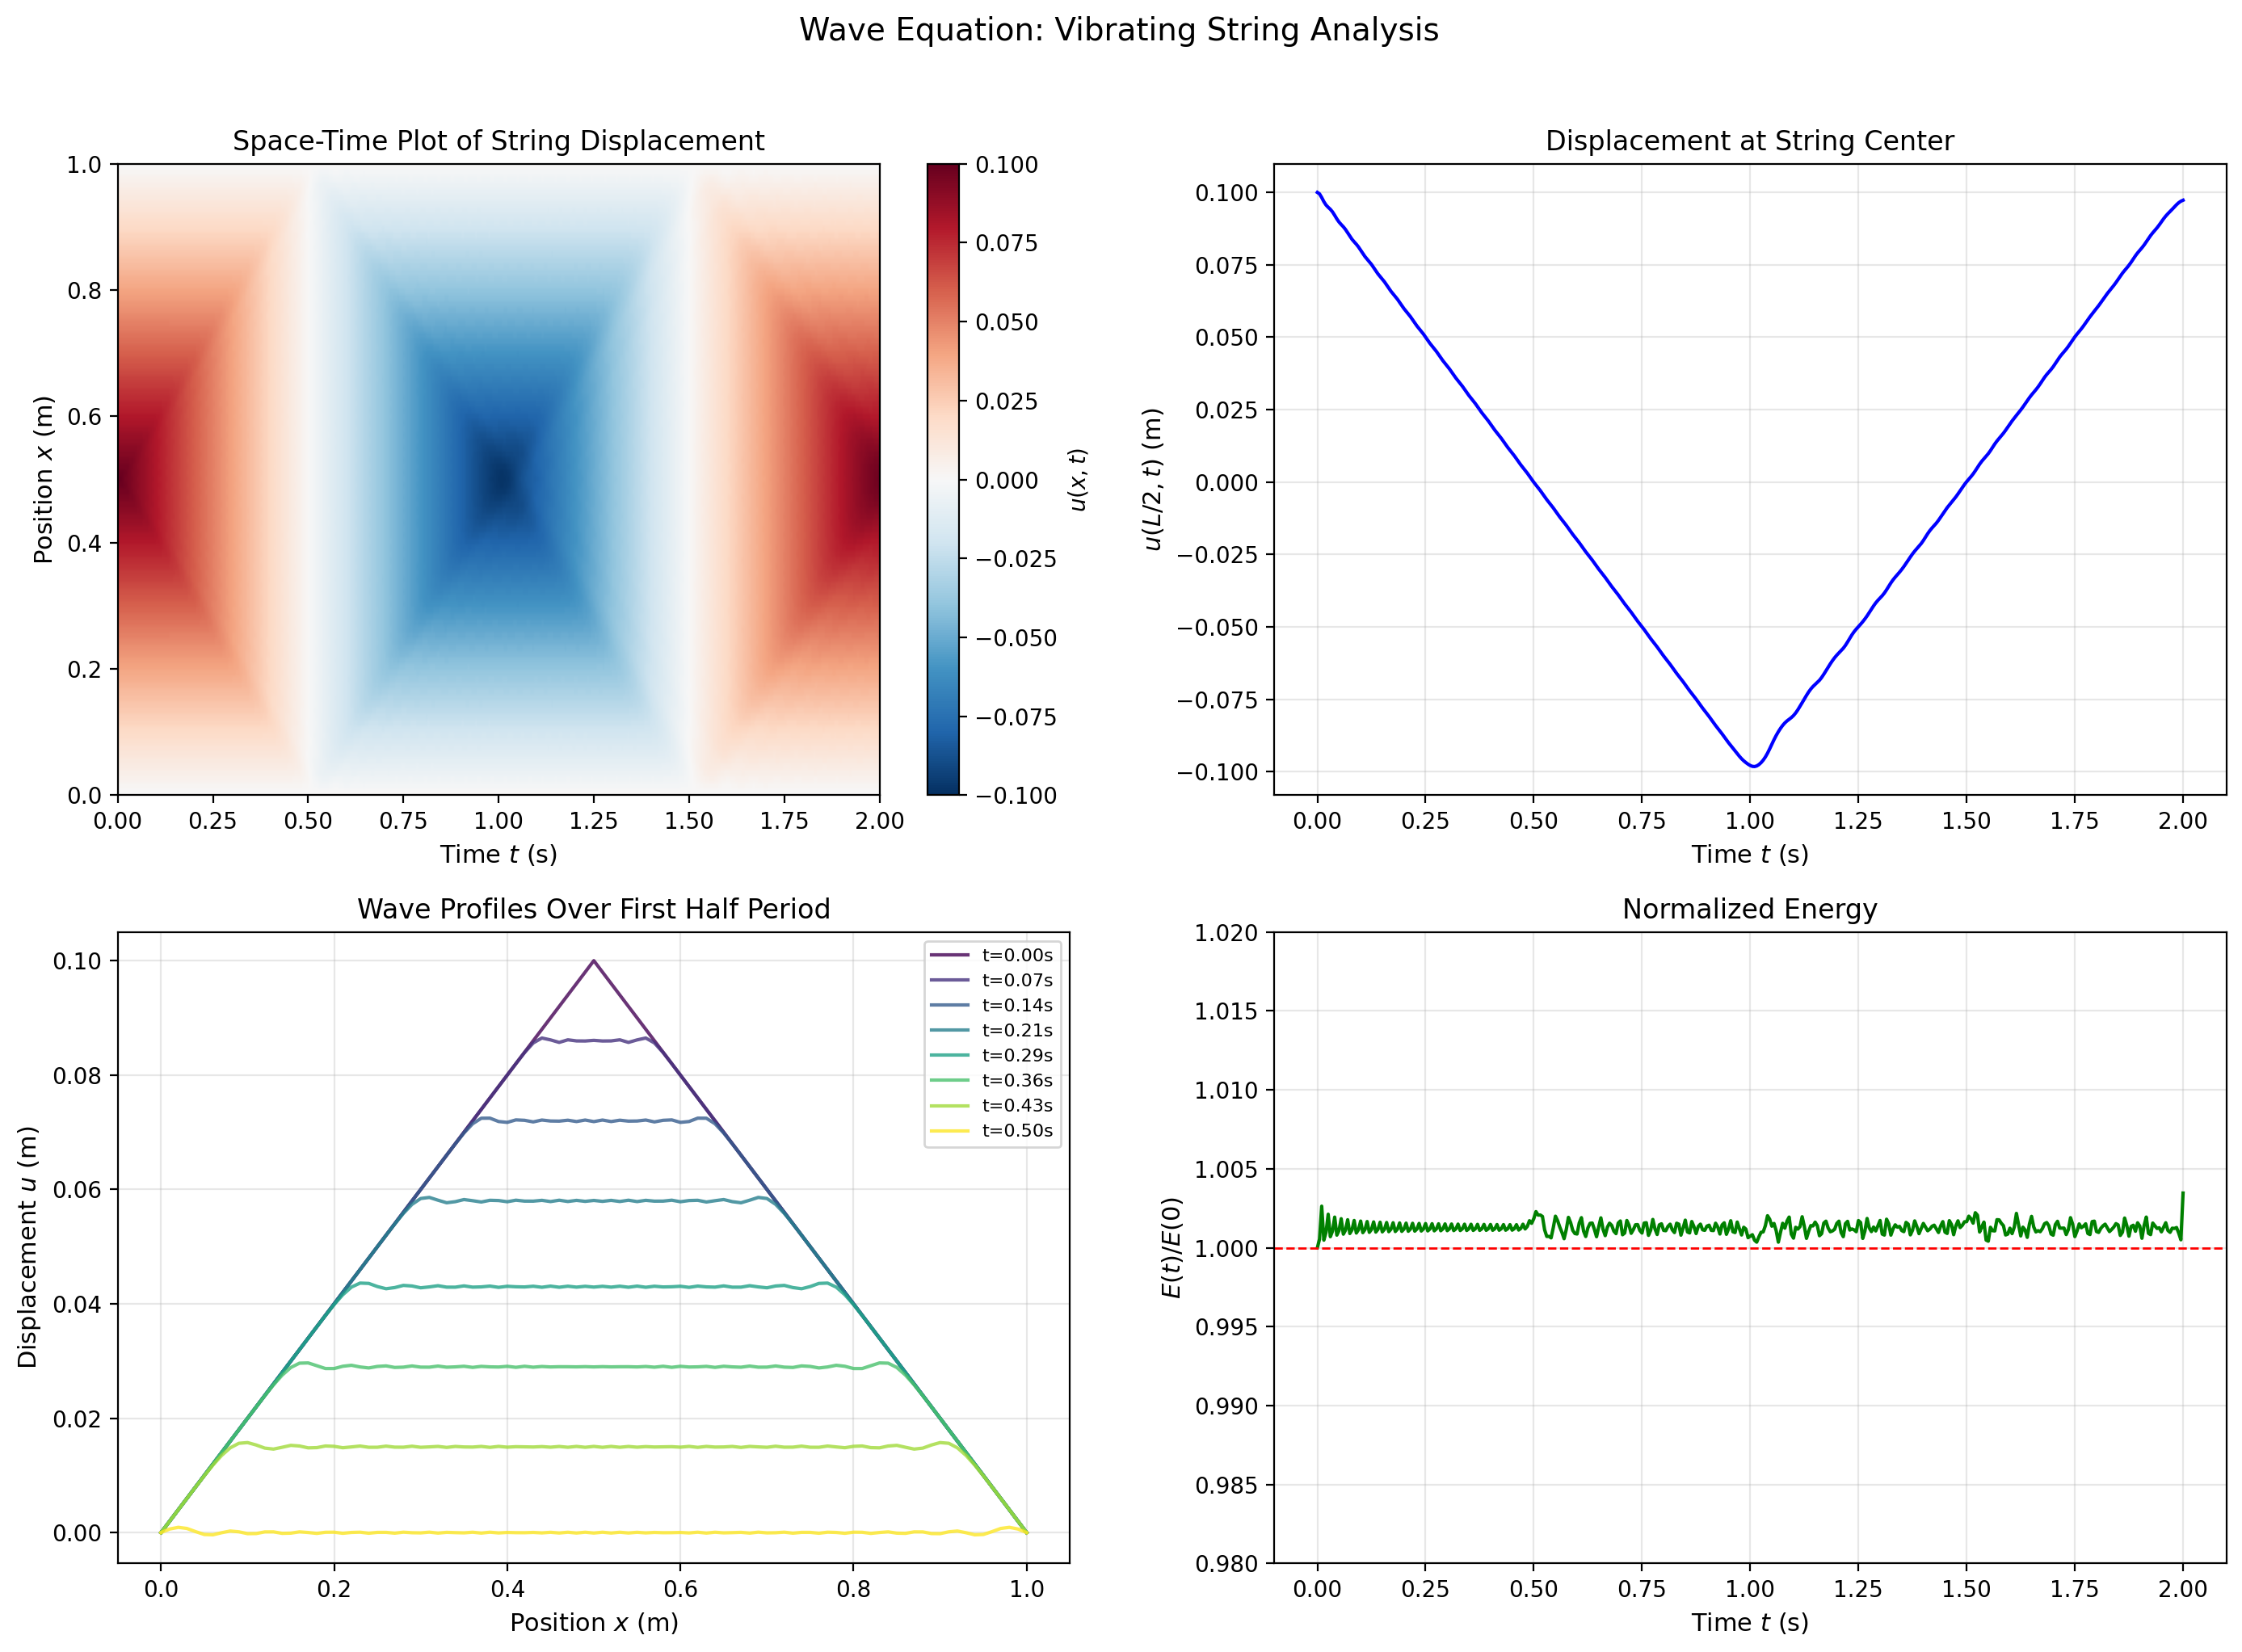

In [9]:
# Create comprehensive summary figure
fig = plt.figure(figsize=(14, 10))

# Colormap plot of u(x, t)
ax1 = fig.add_subplot(221)
im = ax1.imshow(u.T, extent=[0, T_final, 0, L], origin='lower',
                aspect='auto', cmap='RdBu_r', vmin=-0.1, vmax=0.1)
ax1.set_xlabel('Time $t$ (s)', fontsize=11)
ax1.set_ylabel('Position $x$ (m)', fontsize=11)
ax1.set_title('Space-Time Plot of String Displacement', fontsize=12)
plt.colorbar(im, ax=ax1, label='$u(x,t)$')

# Displacement at center point
ax2 = fig.add_subplot(222)
center_idx = Nx // 2
ax2.plot(t, u[:, center_idx], 'b-', linewidth=1.5)
ax2.set_xlabel('Time $t$ (s)', fontsize=11)
ax2.set_ylabel('$u(L/2, t)$ (m)', fontsize=11)
ax2.set_title('Displacement at String Center', fontsize=12)
ax2.grid(True, alpha=0.3)

# Standing wave pattern snapshots
ax3 = fig.add_subplot(223)
colors = plt.cm.viridis(np.linspace(0, 1, 8))
for i, t_snap in enumerate(np.linspace(0, 0.5, 8)):
    idx = int(t_snap / dt)
    ax3.plot(x, u[idx, :], color=colors[i], alpha=0.8, 
             label=f't={t_snap:.2f}s')
ax3.set_xlabel('Position $x$ (m)', fontsize=11)
ax3.set_ylabel('Displacement $u$ (m)', fontsize=11)
ax3.set_title('Wave Profiles Over First Half Period', fontsize=12)
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(True, alpha=0.3)

# Energy conservation
ax4 = fig.add_subplot(224)
ax4.plot(t, energy / energy[0], 'g-', linewidth=1.5)
ax4.set_xlabel('Time $t$ (s)', fontsize=11)
ax4.set_ylabel('$E(t) / E(0)$', fontsize=11)
ax4.set_title('Normalized Energy', fontsize=12)
ax4.set_ylim(0.98, 1.02)
ax4.axhline(y=1, color='r', linestyle='--', linewidth=1)
ax4.grid(True, alpha=0.3)

plt.suptitle('Wave Equation: Vibrating String Analysis', fontsize=14, y=1.02)
plt.tight_layout()

# Save the figure
plt.savefig('wave_equation_vibrating_string_analysis.png', dpi=150, bbox_inches='tight')
print("Figure saved to plot.png")

plt.show()

## Summary

In this notebook, we explored the **one-dimensional wave equation** governing the motion of a vibrating string:

1. **Mathematical Framework**: Derived the wave equation from physical principles and solved it using separation of variables

2. **Numerical Implementation**: Developed a finite difference solver satisfying the CFL stability condition

3. **Physical Insights**:
   - Wave reflections at fixed boundaries cause standing wave patterns
   - Energy is conserved in the ideal (undamped) case
   - The triangular pluck excites only odd harmonics

4. **Fourier Analysis**: Demonstrated how the string motion can be decomposed into normal modes, with excellent agreement between analytical and numerical Fourier coefficients

The wave equation remains fundamental to physics and engineering, with applications ranging from musical acoustics to electromagnetic theory and quantum mechanics.